In [22]:
import torch
import torch.nn as nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(
    batch_size=batch_size, num_steps=num_steps, use_random_iter=True)

In [23]:
def get_params(vocab_size, num_hiddens, device, num_layers=2):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    def three(num_inputs, num_hiddens):
        return (
            normal((num_inputs, num_hiddens)),
            normal((num_hiddens, num_hiddens)),
            torch.zeros(num_hiddens, device=device)
        )

    all_params = []
    num_channel = [[num_inputs, num_hiddens], [num_hiddens, num_hiddens]]
    for i in range(num_layers):
        W_xi, W_hi, b_i = three(*(num_channel[i]))
        W_xf, W_hf, b_f = three(*(num_channel[i]))
        W_xo, W_ho, b_o = three(*(num_channel[i]))
        W_xc, W_hc, b_c = three(*(num_channel[i]))

        params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c]
        for param in params:
            param.requires_grad_(True)

        # all_params.append(params)
        all_params += params

    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_hq, b_q]
    for param in params:
        param.requires_grad_(True)

    # all_params.append(params)
    all_params += params
    return all_params

def init_gru_state(batch_size, num_hiddens, device, num_layers=2):
    state = []
    for _ in range(num_layers):
        state.append((torch.zeros((batch_size, num_hiddens), device=device), 
            torch.zeros((batch_size, num_hiddens), device=device)))
    return state

def lstm(inputs, state, params, num_layers=2):
    gates = 3 * 4
    out_state = []
    for i in range(num_layers):
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c = params[i*gates:(i+1)*gates]
        C, H = state[i]
        outputs = []
        for X in inputs:
            I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
            F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
            O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
            C_tilde = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
            C = (F * C) + (I * C_tilde)
            H = O * torch.tanh(C)
            outputs.append(H.unsqueeze(0))
        inputs = torch.cat(outputs, dim=0)
        out_state.append((C, H))
    
    W_hq, b_q = params[num_layers*gates:]
    outputs = []
    for H in inputs:
        Y = (H @ W_hq) + b_q
        outputs.append(Y)

    outputs = torch.cat(outputs, dim=0)
    return outputs, out_state


perplexity 1.3, 7503.6 tokens/sec on cuda:0
time traveller with a slight accession ofcheerfulness really thi
traveller after the pauserequired for the proper assimilati


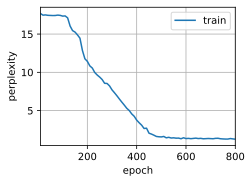

In [29]:
epochs, lr = 800, 2
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_gru_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, epochs, device, use_random_iter=True)

perplexity 1.5, 178760.3 tokens/sec on cuda:0
time traveller smiled are you sure we can move freely inspace ri
traveller smiled are you sure we can move freely inspace ri


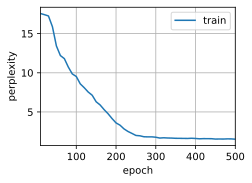

In [26]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr*1.0, num_epochs, device)